# Kaggle Competition

[reference](https://www.kaggle.com/c/uw-madison-gi-tract-image-segmentation/)

## Dataset Description
In this competition we are segmenting organs cells in images. The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.

Each case in this competition is represented by multiple sets of scan slices (each set is identified by the day the scan took place). Some cases are split by time (early days are in train, later days are in test) while some cases are split by case - the entirety of the case is in train or test. The goal of this competition is to be able to generalize to both partially and wholly unseen cases.

Note that, in this case, the test set is entirely unseen. It is roughly 50 cases, with a varying number of days and slices, as seen in the training set.

## How does an entirely hidden test set work?
The test set in this competition is only available when your code is submitted. The sample_submission.csv provided in the public set is an empty placeholder that shows the required submission format; you should perform your modeling, cross-validation, etc., using the training set, and write code to process a non-empty sample submission. It will contain rows with id, class and predicted columns as described in the Evaluation page.

When you submit your notebook, your code will be run against the non-hidden test set, which has the same folder format (<case>/<case_day>/<scans>) as the training data.

## Files
* train.csv - IDs and masks for all training objects.
* sample_submission.csv - a sample submission file in the correct format
* train - a folder of case/day folders, each containing slice images for a particular case on a given day.
Note that the image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice width / height (integers in pixels) and width/height pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

Physical pixel thickness in superior-inferior direction is 3mm.

Columns
* id - unique identifier for object
* class - the predicted class for the object
* segmentation - RLE-encoded pixels for the identified object

In [1]:
from IPython.display import display
from PIL import Image
from scipy.spatial.distance import directed_hausdorff
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import datetime
import glob
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

DATASET_CSV = "train_notna.csv.zip"
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

files = []
for dirname, _, filenames in os.walk("train\\"):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

print("n files:", len(files))
print(files[:5])

cuda
n files: 38496
['train\\case101\\case101_day20\\scans\\slice_0001_266_266_1.50_1.50.png', 'train\\case101\\case101_day20\\scans\\slice_0002_266_266_1.50_1.50.png', 'train\\case101\\case101_day20\\scans\\slice_0003_266_266_1.50_1.50.png', 'train\\case101\\case101_day20\\scans\\slice_0004_266_266_1.50_1.50.png', 'train\\case101\\case101_day20\\scans\\slice_0005_266_266_1.50_1.50.png']


In [2]:
print(os.listdir("train/"))
if not os.path.exists(DATASET_CSV):
    df = pd.read_csv("train.csv")
    df = df.dropna(axis=0).reset_index(drop=True)
    uid = df["id"].unique()
    train_ids, test_ids = train_test_split(uid, test_size=0.2, random_state=42)
    df["split"] = ""
    df.loc[df["id"].isin(train_ids), "split"] = "train"
    df.loc[df["id"].isin(test_ids), "split"] = "test"
    df.to_csv(DATASET_CSV)
else:
    df = pd.read_csv(DATASET_CSV, index_col=0)
df.head()

['case101', 'case102', 'case107', 'case108', 'case11', 'case110', 'case111', 'case113', 'case114', 'case115', 'case116', 'case117', 'case118', 'case119', 'case121', 'case122', 'case123', 'case124', 'case125', 'case129', 'case130', 'case131', 'case133', 'case134', 'case135', 'case136', 'case138', 'case139', 'case140', 'case141', 'case142', 'case143', 'case144', 'case145', 'case146', 'case147', 'case148', 'case149', 'case15', 'case154', 'case156', 'case16', 'case18', 'case19', 'case2', 'case20', 'case22', 'case24', 'case29', 'case30', 'case32', 'case33', 'case34', 'case35', 'case36', 'case40', 'case41', 'case42', 'case43', 'case44', 'case47', 'case49', 'case53', 'case54', 'case55', 'case58', 'case6', 'case63', 'case65', 'case66', 'case67', 'case7', 'case74', 'case77', 'case78', 'case80', 'case81', 'case84', 'case85', 'case88', 'case89', 'case9', 'case90', 'case91', 'case92']


,id,class,segmentation,split
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,test
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,train
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,train
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,test
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,train


In [3]:
def mask2rle(img: np.ndarray):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def rle2mask(mask_rle: str, shape: tuple[int, int] = (266, 266)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [4]:
input_paths_metadata = []
pattern = r".*(case\d+)_(day\d+)\\scans\\(slice_\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+.\d+).png$"
for f in files:
    m = re.match(pattern, f)
    if m:
        input_paths_metadata.append(
            dict(
                case=m.group(1),
                day=m.group(2),
                slice=m.group(3),
                resolution_w=int(m.group(4)),
                resolution_h=int(m.group(5)),
                pixel_w=float(m.group(6)),
                pixel_h=float(m.group(7)),
                path=f,
            )
        )
    else:
        print("no match!")
input_paths_metadata_df = pd.DataFrame(input_paths_metadata)
input_paths_metadata_df

,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path
0,case101,day20,slice_0001,266,266,1.5,1.5,train\case101\case101_day20\scans\slice_0001_2...
1,case101,day20,slice_0002,266,266,1.5,1.5,train\case101\case101_day20\scans\slice_0002_2...
2,case101,day20,slice_0003,266,266,1.5,1.5,train\case101\case101_day20\scans\slice_0003_2...
3,case101,day20,slice_0004,266,266,1.5,1.5,train\case101\case101_day20\scans\slice_0004_2...
4,case101,day20,slice_0005,266,266,1.5,1.5,train\case101\case101_day20\scans\slice_0005_2...
...,...,...,...,...,...,...,...,...
38491,case92,day0,slice_0140,266,266,1.5,1.5,train\case92\case92_day0\scans\slice_0140_266_...
38492,case92,day0,slice_0141,266,266,1.5,1.5,train\case92\case92_day0\scans\slice_0141_266_...
38493,case92,day0,slice_0142,266,266,1.5,1.5,train\case92\case92_day0\scans\slice_0142_266_...
38494,case92,day0,slice_0143,266,266,1.5,1.5,train\case92\case92_day0\scans\slice_0143_266_...


In [5]:
df = pd.read_csv(DATASET_CSV, index_col=0)
id_split = pd.DataFrame(df["id"].str.split("_", n=2).tolist(), columns=["case", "day", "slice"])
df = df.join(id_split)
df = pd.merge(df, input_paths_metadata_df, how="inner", on=["case", "day", "slice"])
classes = df["class"].unique().tolist()
keep_cols = [
    "id",
    "split",
    # "case",
    # "day",
    # "slice",
    "resolution_w",
    "resolution_h",
    # "pixel_w",
    # "pixel_h",
    "path",
]
df = df.pivot_table(index=keep_cols, columns="class", values="segmentation", aggfunc="first", fill_value="")
df = df.reset_index()

for c in classes:
    df[c] = df.apply(lambda r: rle2mask(r[c], (r["resolution_h"], r["resolution_w"])), axis=1)

train_df = df[df["split"] == "train"].drop(columns=["split"])
test_df = df[df["split"] == "test"].drop(columns=["split"])

In [6]:
print(f"train-test ratio: {len(train_df) / len(df)}-{len(test_df) / len(df)}")

train-test ratio: 0.8-0.2


In [7]:
# need to resize all images to same resolution, therefore also the segmentation masks
df[["resolution_w", "resolution_h"]].value_counts()

resolution_w  resolution_h
266           266             10955
360           310              4861
276           276               718
234           234                56
Name: count, dtype: int64

In [8]:
def combine_masks(row: pd.Series):
    masks = row[classes]
    combined_mask = np.zeros((*masks.iloc[0].shape, 3))
    for i, c in enumerate(classes):
        combined_mask[..., i] = masks[c]
    combined_mask = combined_mask / combined_mask.max()
    return combined_mask


def get_classes(row: pd.Series):
    return tuple(c for c in classes if row[c].any())

class
id                                        case74_day19_slice_0086
resolution_w                                                  266
resolution_h                                                  266
path            train\case74\case74_day19\scans\slice_0086_266...
large_bowel     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
small_bowel     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
stomach         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 14345, dtype: object

stomach: red
large bowel: green
small bowel: blue
classes: stomach


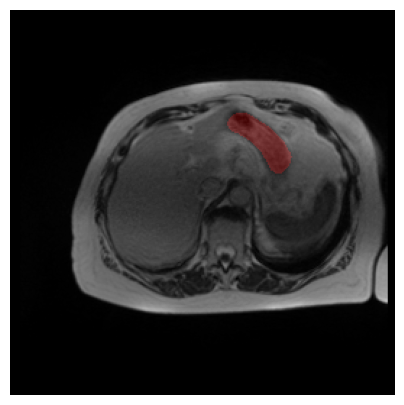

In [9]:
random_case = train_df.sample(1).iloc[0]
display(random_case)

combined_mask = combine_masks(random_case)

legend = {
    0: ("stomach", "red"),
    1: ("large bowel", "green"),
    2: ("small bowel", "blue"),
}

for i, (name, color) in legend.items():
    print(f"{name}: {color}")

print("classes:", ", ".join(get_classes(random_case)))
img = plt.imread(random_case["path"])
cmap = mcolors.LinearSegmentedColormap.from_list("", ["black", "red", "green", "blue"])
cmap.set_under("none")  # Set under color

# Plot the image and the combined mask
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap="gray")
plt.imshow(combined_mask, alpha=0.25, cmap=cmap, clim=[0.5, 1])
plt.axis("off")
plt.show()

images must have same shape

In [10]:
def reshape_mask(mask_arr: np.ndarray, shape: tuple[int, int] = (128, 128)):
    mask_arr = resize(mask_arr, shape, mode="constant")
    mask_arr = (mask_arr > 0).astype(np.float32)
    mask_tensor = torch.from_numpy(mask_arr).float()
    mask_tensor = mask_tensor.unsqueeze(0)
    _max = mask_tensor.max()
    if _max > 0:  # normalize
        mask_tensor = mask_tensor / _max
    return mask_tensor


def reshape_image(image: Image.Image, shape: tuple[int, int] = (128, 128)):
    image_reshaped = image.resize(shape)
    image_arr = np.array(image_reshaped)
    image_tensor = torch.from_numpy(image_arr).float()
    image_tensor = image_tensor.unsqueeze(0)  # add gray scale channel as first dim
    _max = image_tensor.max()
    if _max > 0:  # normalize
        image_tensor = image_tensor / _max
    return image_tensor


def extract_data(row: pd.Series):
    return {
        "image": reshape_image(Image.open(row["path"])),
        "stomach": reshape_mask(row["stomach"]),
        "large_bowel": reshape_mask(row["large_bowel"]),
        "small_bowel": reshape_mask(row["small_bowel"]),
    }


extract_data(random_case)

{'image': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0011, 0.0011],
          [0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011],
          [0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011],
          ...,
          [0.0000, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
          [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
          [0.0000, 0.0000, 0.0011,  ..., 0.0000, 0.0000, 0.0000]]]),
 'stomach': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'large_bowel': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'small_bow

In [11]:
def preprocess_data(df: pd.DataFrame):
    preprocessing_start = time.time()
    data = df.apply(lambda r: extract_data(r), axis=1).tolist()
    preprocessing_end = time.time()
    preprocessing_elapsed = preprocessing_end - preprocessing_start
    print(f"took {preprocessing_elapsed} seconds for preprocessing {len(df)} rows")
    return data


In [12]:
n_rows = 100
start = time.time()
preprocess_data(train_df.sample(n_rows))
end = time.time()
elapsed = end - start

estimate = datetime.timedelta(seconds=len(train_df) * elapsed / n_rows)
print(f"estimated time for {len(train_df)} rows: {estimate}")

took 1.4260950088500977 seconds for preprocessing 100 rows
estimated time for 13272 rows: 0:03:10.202359


In [13]:
cached_train_data = "train_data.pickle"

if os.path.exists(cached_train_data):
    print("loading cached data")
    with open(cached_train_data, "rb") as f:
        train_data = pickle.load(f)
else:
    print("caching data")
    train_data = preprocess_data(train_df)
    with open(cached_train_data, "wb") as f:
        pickle.dump(train_data, f)

cached_test_data = "test_data.pickle"

if os.path.exists(cached_test_data):
    print("loading cached data")
    with open(cached_test_data, "rb") as f:
        test_data = pickle.load(f)
else:
    print("caching data")
    test_data = preprocess_data(test_df)
    with open(cached_test_data, "wb") as f:
        pickle.dump(test_data, f)

len(train_data)

loading cached data
loading cached data


13272

In [14]:
def format_data_for_dataset(sample: dict[str, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    img0 = sample["image"]
    img1 = sample["stomach"]  # red
    img2 = sample["large_bowel"]  # green
    img3 = sample["small_bowel"]  # blue
    # output shapes should be [3, 128, 128]
    stacked_img = torch.stack([img1, img2, img3], dim=0)
    stacked_img = stacked_img.squeeze(1)
    return img0, stacked_img

img shape: torch.Size([1, 128, 128])
mask shape: torch.Size([3, 128, 128])


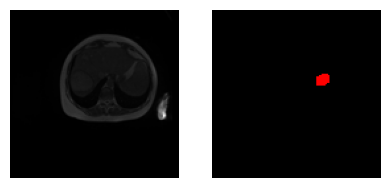

In [15]:
idx = random.randint(0, len(train_data) - 1)

img, msk = format_data_for_dataset(train_data[idx])
print(f"img shape: {img.shape}")
print(f"mask shape: {msk.shape}")

img, msk = torch.squeeze(img.permute(1, 2, 0)), torch.squeeze(msk.permute(1, 2, 0))
img = img.cpu().numpy()
msk = msk.cpu().numpy()

assert np.all(msk <= 1.0) and np.all(msk >= 0.0)

# Convert the NumPy array to PIL image
img = Image.fromarray((img * 255).astype("uint8"))
msk = Image.fromarray((msk * 255).astype("uint8"))

# Display the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(msk)
plt.axis("off")
plt.show()

Problema di classificazione pixel per pixel.
Ogni pixel puo' appartenere a 4 categorie:
- assenza di tumore (nero)
- tumore rosso
- tumore verde
- tumore blu

In [16]:
class SegmentationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        image_tensor, mask_tensor = format_data_for_dataset(x)
        return image_tensor.to(device), mask_tensor.to(device)


batch_size = 48

train_dataset = SegmentationDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = SegmentationDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to("cpu")
train_labels = train_labels.to("cpu")
print(f"Input feature batch shape: {train_features.size()}")
print(f"Output labels batch shape: {train_labels.size()}")

Input feature batch shape: torch.Size([48, 1, 128, 128])
Output labels batch shape: torch.Size([48, 3, 128, 128])


In [17]:
# Define single convolutional block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        # default gray scale
        super(UNet, self).__init__()
        # Contracting path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Deepest layer
        self.middle = conv_block(512, 1024)
        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        middle = self.middle(self.pool(enc4))
        # Expanding path
        dec4 = self.dec4(torch.cat([self.upconv4(middle), enc4], 1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], 1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], 1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], 1))
        y = self.out_conv(dec1)
        y = torch.sigmoid(y)
        return y

In [18]:
model = UNet().to(device)
if os.path.exists("model.pth"):
    print("loading model")
    model.load_state_dict(torch.load("model.pth"))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
elapsed = 0
loss = torch.tensor(0)
for epoch in range(num_epochs):
    start = time.time()
    total_iterations = len(train_dataloader)
    for (inputs, targets) in tqdm.tqdm(train_dataloader, total=total_iterations):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward Pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, targets)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    end = time.time()
    elapsed += end - start
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}, Time: {end-start:.5f} seconds")
    # Save the trained model
    torch.save(model.state_dict(), "model.pth")

print(f"took {datetime.timedelta(seconds=elapsed)} seconds for {num_epochs} epochs")

100%|██████████| 277/277 [01:58<00:00,  2.34it/s]


Epoch [1/10], Loss: 0.06508, Time: 118.40705 seconds


100%|██████████| 277/277 [02:00<00:00,  2.30it/s]


Epoch [2/10], Loss: 0.04688, Time: 120.29786 seconds


100%|██████████| 277/277 [02:00<00:00,  2.30it/s]


Epoch [3/10], Loss: 0.03453, Time: 120.69461 seconds


100%|██████████| 277/277 [02:01<00:00,  2.29it/s]


Epoch [4/10], Loss: 0.03507, Time: 121.04510 seconds


100%|██████████| 277/277 [02:01<00:00,  2.29it/s]


Epoch [5/10], Loss: 0.02224, Time: 121.04903 seconds


100%|██████████| 277/277 [02:00<00:00,  2.29it/s]


Epoch [6/10], Loss: 0.01391, Time: 120.99998 seconds


100%|██████████| 277/277 [02:01<00:00,  2.29it/s]


Epoch [7/10], Loss: 0.01967, Time: 121.03514 seconds


100%|██████████| 277/277 [02:01<00:00,  2.29it/s]


Epoch [8/10], Loss: 0.01400, Time: 121.12448 seconds


100%|██████████| 277/277 [02:01<00:00,  2.28it/s]


Epoch [9/10], Loss: 0.01180, Time: 121.29590 seconds


100%|██████████| 277/277 [02:01<00:00,  2.29it/s]


Epoch [10/10], Loss: 0.01128, Time: 121.11436 seconds
took 0:20:07.063519 seconds for 10 epochs


In [18]:
# Load model
loaded_model = UNet()
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()
loaded_model = loaded_model.to(device)

test_sample_in, test_sample_out = next(iter(test_dataloader))
test_sample_in = test_sample_in.to(device)
test_sample_pred = loaded_model(test_sample_in)
test_sample_out = test_sample_out.detach().cpu()
test_sample_pred = test_sample_pred.detach().round().cpu()  # round to 0 or 1
test_sample_in = test_sample_in.cpu()

# test_sample_in, test_sample_out, test_sample_pred = test_sample_in[0], test_sample_out[0], test_sample_pred[0]
test_sample_in.shape, test_sample_out.shape, test_sample_pred.shape

(torch.Size([48, 1, 128, 128]),
 torch.Size([48, 3, 128, 128]),
 torch.Size([48, 3, 128, 128]))

In [19]:
def scale(tensor: torch.Tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    tensor = tensor.to(torch.uint8)
    return tensor


def plot_prediction(tensor_in: torch.Tensor, tensor_out: torch.Tensor, tensor_pred: torch.Tensor):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    tensor_in = tensor_in.squeeze().numpy()
    tensor_out = tensor_out.permute(1, 2, 0).numpy()
    tensor_pred = tensor_pred.permute(1, 2, 0).numpy()
    axs[0].imshow(tensor_in, cmap="gray")
    axs[0].set_title("input")
    axs[1].imshow(tensor_out, cmap="gray")
    axs[1].set_title("ground truth")
    axs[2].imshow(tensor_pred, cmap="gray")
    axs[2].set_title("prediction")
    for ax in axs:
        ax.axis("off")
    plt.show()

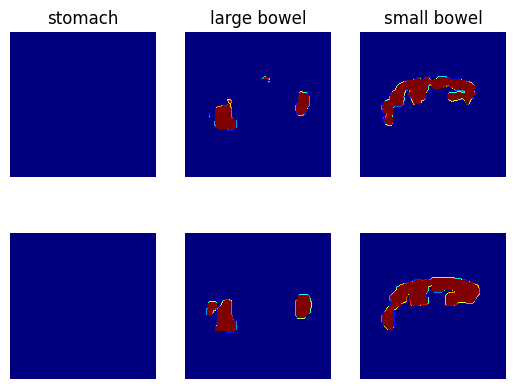

predicted above, ground truth below


In [20]:
random_idx = random.randint(0, len(test_sample_in) - 1)

y_pred = test_sample_pred[random_idx].numpy()
y_true = test_sample_out[random_idx].numpy()
for i in range(1, 4):
    plt.subplot(2, 3, i)
    plt.title(legend[i - 1][0])
    plt.imshow(y_pred[i - 1], cmap="jet")
    plt.axis("off")
    plt.subplot(2, 3, i + 3)
    plt.imshow(y_true[i - 1], cmap="jet")
    plt.axis("off")
plt.show()
print("predicted above, ground truth below")

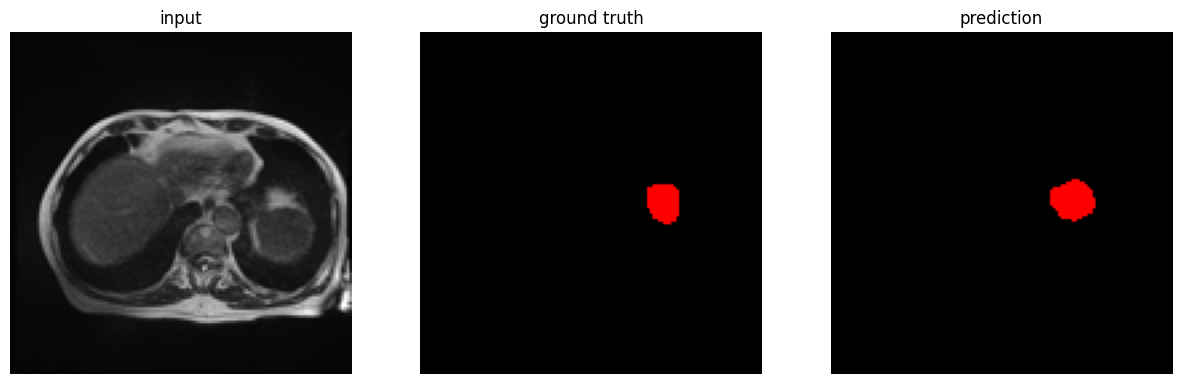

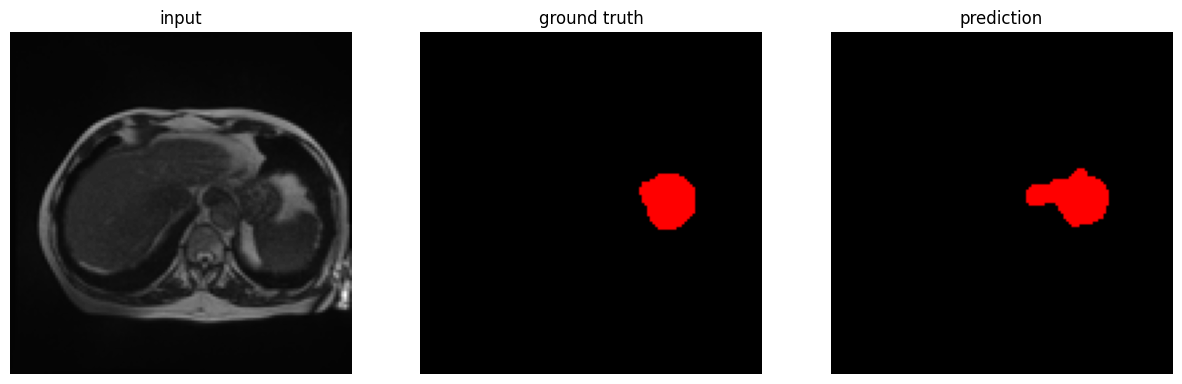

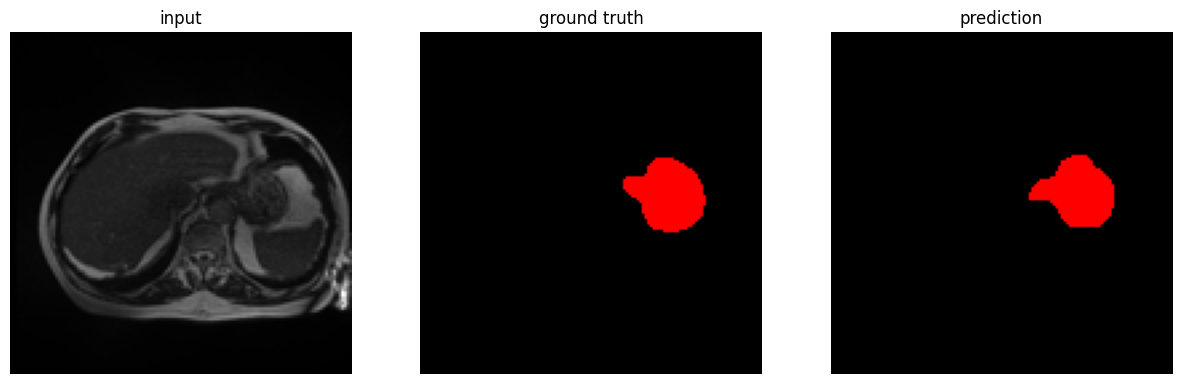

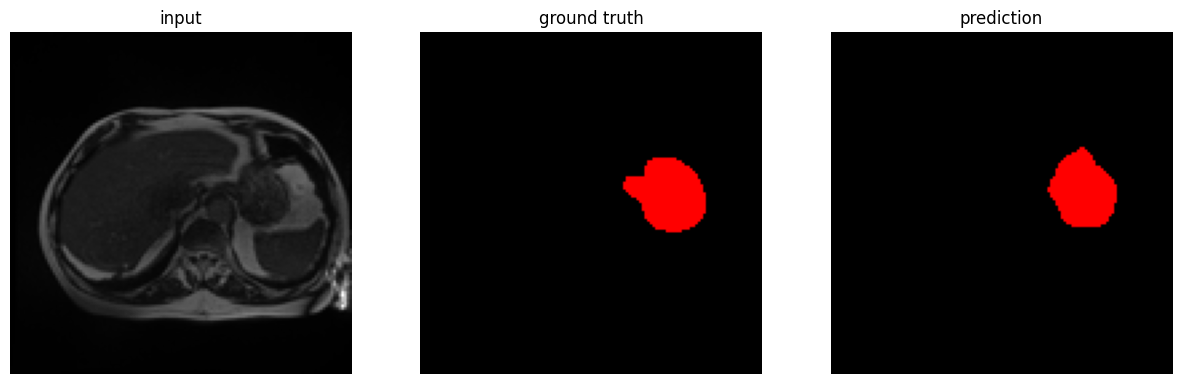

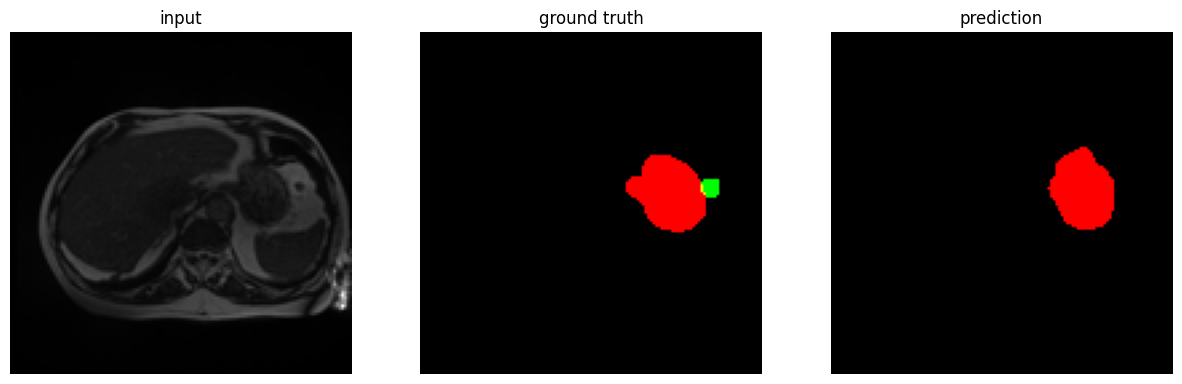

In [21]:
for i in range(5):
    plot_prediction(test_sample_in[i], test_sample_out[i], test_sample_pred[i])

In [22]:
def segmentation_mask_to_coordinates(mask: torch.Tensor) -> np.ndarray:
    # given a binary mask, return the coordinates of the pixels that are set to 1
    coords = np.argwhere(mask.numpy() > 0)
    return coords


def hausdorff_distance(u: np.ndarray, v: np.ndarray) -> float:
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])


def relative_hausdorff_distance(u: np.ndarray, v: np.ndarray, max_dist: float) -> float:
    # return the distance scaled by the maximum possible distance
    return hausdorff_distance(u, v) / max_dist


all_zeros = np.zeros((128, 128))
all_ones = np.ones((128, 128))
max_dist = hausdorff_distance(all_zeros, all_ones)

In [23]:
measures = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        current = dict()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = loaded_model(inputs)
        targets = targets.detach().cpu()
        outputs = outputs.detach().round().cpu()
        for i in range(3):
            label = legend[i][0]
            # true positive
            tp = (outputs[i] * targets[i]).sum()
            # false positive
            fp = (outputs[i] * (1 - targets[i])).sum()
            # precision
            precision = tp / (tp + fp)
            precision = precision.item()
            # dice coefficient
            intersection = tp
            dice = (2.0 * intersection) / (outputs[i].sum() + targets[i].sum())
            dice = dice.item()
            # hausdorff distance
            pred_coords = segmentation_mask_to_coordinates(outputs[i])
            true_coords = segmentation_mask_to_coordinates(targets[i])
            dist = relative_hausdorff_distance(pred_coords, true_coords, max_dist)
            current[label + "_precision"] = precision
            current[label + "_dice"] = dice
            current[label + "_dist"] = dist
            # print(f"precision: {precision:.2f}, dice: {dice:.2f}, dist: {dist:.2f}")
        # save results
        measures.append(current)

In [24]:
measures_df = pd.DataFrame(measures)
measures_df = measures_df.mean().to_frame().reset_index()
measures_df = (
    measures_df.join(measures_df["index"].str.split("_", expand=True).rename(columns={0: "class", 1: "measure"}))
    .drop(columns=["index"])
    .rename(columns={0: "value"})
    .pivot_table(index="class", columns="measure", values="value")
)
measures_df

measure,dice,dist,precision
class,,,
large bowel,0.880793,0.458837,0.895138
small bowel,0.878690,0.459269,0.901101
stomach,0.867628,0.438018,0.889778
